In [59]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import random
from collections import defaultdict
import math as math

In [2]:
def generate_scenario(n, S, T):
    #S scenarios in second stage, T in extended stage
    scenario = []
    pT=np.random.rand(S,T)
    pT=pT/sum(sum(pT))
    pT=pT.tolist()
    for i in range(n):
        x=[]
        for j in range(S):
            xS=random.uniform(0,0.6)
            x1=[]
            for k in range(T):
                xT=random.uniform(0,1)
                x2=[xS,xT,pT[j][k]]
                x1.append(x2)
            x.append(x1)
        scenario.append(x)
    return scenario 
    #n*S*T*3 list, each element is [\xi_2,\xi_1,p]
    #for example, sum(scenario[0][0][:][2]) is probability for S=0. 
    #             scenario[0][0][0][2]/sum(scenario[0][0][:][2]) is probability for T=0|S=0. 
    #             scenario[i] is scenario for agent i
    
    
#this part is working fine.
scenario = generate_scenario(3,3,3)
#scenario, [[scenario[i][0][j][1] for j in range(3)] for i in range(3) ]
#scenario, [scenario[i][0][j][2]/sum(scenario[i][0][k][2] for k in range(3)) for j in range(3)]

In [3]:
#scn = [ sum(sum((scenario[i][s][t][0] + (1-scenario[i][s][t][0])*scenario[i][s][t][1])*scenario[i][s][t][2]/sum(scenario[i][s][t][2] for t in range(3)) for t in range(3)) for i in range(3)) for s in range(3)]
#scn = [ [sum(scenario[i][s][t][0] + (1-scenario[i][s][t][0])*scenario[i][s][t][1] for i in range(3)) for t in range(3)] for s in range(3)]
scenario
#scn, [sum(scenario[0][s][t][2] for t in range(3)) for s in range(3)]
#scenario[1][0][0][0]+(1-scenario[1][0][0][0])*scenario[1][0][0][1]

[[[[0.30766373505103495, 0.5332444495536139, 0.12951419265147404],
   [0.30766373505103495, 0.5743490535179966, 0.30815462817505973],
   [0.30766373505103495, 0.4446303145870867, 0.014226077723047945]],
  [[0.5941269165861761, 0.2620003643290618, 0.03578365286140128],
   [0.5941269165861761, 0.9667883387252189, 0.0023633409561193883],
   [0.5941269165861761, 0.36125103097872346, 0.25396828276730404]],
  [[0.4488312322911512, 0.4803736667281261, 0.07176071057083945],
   [0.4488312322911512, 0.8044145224671704, 0.04930972259682805],
   [0.4488312322911512, 0.3043981863579567, 0.13491939169792608]]],
 [[[0.18531982133510783, 0.17851409440091215, 0.12951419265147404],
   [0.18531982133510783, 0.7779548013933828, 0.30815462817505973],
   [0.18531982133510783, 0.10704735040148383, 0.014226077723047945]],
  [[0.3288189773895119, 0.8391263782257051, 0.03578365286140128],
   [0.3288189773895119, 0.5567708252957916, 0.0023633409561193883],
   [0.3288189773895119, 0.3446604070215601, 0.2539682827

In [4]:
def evaluation(x, alpha):
    if (x<=alpha/2):
        return 4*((x/alpha) - (x/alpha)**2)
    else:
        return 1

#evaluation function f(x) = min(1, g(x))
#g(x) = (4/alpha^2)*(alpha*x - x^2), alpha = K/(n-1)

Solve for benchmark without order constraint

In [5]:
def subproblem_b(x, s, scenario, K, output_yz):
    
    #x is a 1*n vector, decision variable for 1st stage
    #s is the s_st scenario we currently want to solve
    #scenario is the S*T*3 matrix we generated before
    #K is total resources allowed that decides evaluation function
    
    #if output_yz==1, then return y. if ==2, return z. used for construct benchmark variable
    
    n=len(x)
    T=len(scenario[0][0])
    alpha=2*K
    
    sp = gp.Model("subproblem")
    
    #w = sp.addVars(n,   vtype=GRB.CONTINUOUS, name="w", lb=list(np.zeros(n)))
    w = [evaluation(scenario[i][s][0][0]*x[i], alpha) for i in range(n)]
    
    z = sp.addVars(n,n, vtype=GRB.CONTINUOUS, name="z", lb=list(np.zeros((n,n)))) #reallocate
    y = sp.addVars(n,   vtype=GRB.CONTINUOUS, name="y", lb=list(np.zeros(n))) #new resources
    
    scenario_extended = [[scenario[i][s][j][1]*(1-scenario[i][s][j][0]) for j in range(T)]  for i in range(n)]
    #n*T list, [i,j] is r_i(\xi^{s,j})
    prob_extended_list = [scenario[0][s][j][2]/sum(scenario[0][s][k][2] for k in range(T)) for j in range(T)]
    prob_extended = dict([(t,prob_extended_list[t]) for t in range(T)])
    #conditional probability of extended stage, conditioned by scenario s at second stage

    extended_obj     = sp.addVars(n,T,vtype=GRB.CONTINUOUS, name="extended_obj", lb=list(np.zeros((n,T))))
    extended_obj_sum = sp.addVars(T,vtype=GRB.CONTINUOUS, name="extended_obj_sum")
    extended_obj_exp = sp.addVar(vtype=GRB.CONTINUOUS, name="extended_obj_exp")

    reallo_cost = 0.01

    sp.setObjective( sum(w) - reallo_cost*z.sum() + extended_obj_exp, GRB.MAXIMIZE)

    reallocate = sp.addConstrs( (y[i] == ((1-scenario[i][s][0][0])*x[i] + z.sum('*',i)-z.sum(i,'*')) for i in range(n)), name = 'reallocate')
    
    extended_ub_evaluation = sp.addConstrs( (extended_obj[i,t] <= 4 * ((scenario_extended[i][t]*y[i]/alpha) - (scenario_extended[i][t]*scenario_extended[i][t]*y[i]*y[i]/(alpha*alpha))) for i in range(n) for t in range(T)), name = 'extended_ub_evaluation' )
    extended_sum = sp.addConstrs( (extended_obj_sum[t] == extended_obj.sum('*',t) for t in range(T)), name = 'extended_sum')
    extended_exp = sp.addConstr( (extended_obj_exp == extended_obj_sum.prod(prob_extended)), name = 'extended_exp')

    sp.setParam('OutputFlag', 0)
    sp.setParam('QCPDual', 1)
    
    sp.optimize()
    
    if sp.status == GRB.OPTIMAL:
        
        feas = 1
        
        cut_val = sp.ObjVal
        
        lmbd = [reallocate[i].Pi for i in range(n)]
        
        cut_subdiff = [lmbd[i]*(1-scenario[i][s][0][0]) + 4*(1-2*(scenario[i][s][0][0]/alpha)*x[i])*(scenario[i][s][0][0]/alpha) for i in range(n)]
       
        if output_yz==0:
            return cut_val, cut_subdiff, feas
        elif output_yz==1:
            return [y[i].x for i in range(n)]
        elif output_yz==2:
            return [[z[i,j].x for i in range(n)] for j in range(n)]
    
    else:    
        print("infeasible", sp.status)

In [6]:
def masterproblem_b(x_start, n, K, scenario):
    
    max_it = 1e4
    S = len(scenario[0])
    T = len(scenario[0][0])
    prob_s = [sum(scenario[0][s][t][2] for t in range(T)) for s in range(S)]
    
    prob_s_dict = dict([(s, prob_s[s]) for s in range(S)])
    
    mp = gp.Model("masterproblem")
    
    x = mp.addVars(n,   vtype=GRB.CONTINUOUS, name="x", lb=list(np.zeros(n)))
    v = mp.addVars(S,   vtype=GRB.CONTINUOUS, name="v")
    
    mp.setObjective(v.prod(prob_s_dict), GRB.MAXIMIZE)
    
    mp.addConstr( x.sum() <= K )
    
    mp.setParam('OutputFlag', 0)
    
    it = 0 #iteration
    
    x_current_iter = x_start #n*1 vector
    
    while (it<max_it):
        
        stop_crit = 0
        optm_sec_stage = list(np.zeros(S))
        
        for s in range(S):
        
            (val, subdiff, feas) = subproblem_b(x_current_iter, s, scenario, K, 0)
        
            if feas==1:
                subdiff = dict([(i,subdiff[i]) for i in range(n)])
                mp.addConstr( v[s] <= val + x.prod(subdiff) - sum(subdiff[i]*x_current_iter[i] for i in range(n)) )
                
                optm_sec_stage[s] = val
        
        mp.optimize()
        
        for i in range(n):
            x_current_iter[i] = x[i].x
        
        for s in range(S):
            stop_crit += abs(optm_sec_stage[s]-v[s].X)
        
        if ( stop_crit < 1e-5 ):
            break;
            
        it = it + 1
    
    return [v[s].x for s in range(S)], [x[i].x for i in range(n)]
        

In [8]:
n = 3; #number of agents
K = 5; #maximum resources stored
S = 3;
T = 3;
alpha = 2*K;
reallo_cost=0.01
(v_rn,x_rn) = masterproblem_b([1,1,1], n, K, scenario)
y_rn = [subproblem_b(x_rn, s, scenario, K, 1) for s in range(S)]
z_rn = [subproblem_b(x_rn, s, scenario, K, 2) for s in range(S)]
w_rn = [ [sum(evaluation(x_rn[i]*scenario[i][s][0][0], alpha) for i in range(n))-reallo_cost*sum([sum(z_rn[s][i]) for i in range(n)])+sum(evaluation(y_rn[s][i]*scenario[i][s][t][1]*(1-scenario[i][s][0][0]), alpha) for i in range(n)) for t in range(T)] for s in range(S)]
#w_rn is a S*T matrix

#so benchmark at second stage scenario s is w_rn[s], with p=scenario[0][0][t][2]/sum(scenairo[0][0][t][2] for t in range(T))
#bench mark at first stage is v_rn

In [11]:
w_rn, v_rn, x_rn

([[0.9273152526754274, 1.2962538594233313, 1.0328269986041545],
  [1.2552769792900447, 1.0990619367773784, 0.9669973386895645],
  [1.0893743745117388, 1.2296126959807658, 0.9442674356301888]],
 [1.182222319651281, 1.0033805126454112, 1.0399096711474431],
 [3.0581167088015366, 0.6921396979504538, 1.2497435932480094])

if using a simple benchmark

In [12]:
w_bm = [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]]
v_bm = [sum(w_bm[s][t]*scenario[0][s][t][2] for t in range(T))/sum(scenario[0][s][t][2] for t in range(T)) for s in range(S)]

Solving the problem with stochastic dominant constraints

In [183]:
def subproblem(x, s, scenario, K, w_bm):
    
    n=len(x)
    T=len(scenario[0][0])
    alpha=2*K
    reallo_cost = 0.01
    
    sp = gp.Model("subproblem")
    
    w = [evaluation(scenario[i][s][0][0]*x[i], alpha) for i in range(n)]
    
    z = sp.addVars(n,n, vtype=GRB.CONTINUOUS, name="z", lb=list(np.zeros((n,n)))) #reallocate
    y = sp.addVars(n,   vtype=GRB.CONTINUOUS, name="y", lb=list(np.zeros(n))) #new resources
    
    shift = sp.addVar(vtype=GRB.CONTINUOUS, name="shift", lb=-GRB.INFINITY)
    
    obj_determined = sp.addVar(vtype=GRB.CONTINUOUS, name="obj_determined", lb=-GRB.INFINITY)
    obj_det = sp.addConstr( obj_determined == sum(w) - reallo_cost*z.sum(), name='obj_det' )
    
    scenario_extended = [[scenario[i][s][j][1]*(1-scenario[i][s][j][0]) for j in range(T)]  for i in range(n)]
    #n*T list, [i,j] is r_i(\xi^{s,j})
    prob_extended_list = [scenario[0][s][j][2]/sum(scenario[0][s][k][2] for k in range(T)) for j in range(T)]
    prob_extended = dict([(t,prob_extended_list[t]) for t in range(T)])
    #conditional probability of extended stage, conditioned by scenario s at second stage

    extended_obj     = sp.addVars(n,T,vtype=GRB.CONTINUOUS, name="extended_obj", lb=list(np.zeros((n,T))))
    extended_obj_sum = sp.addVars(T,vtype=GRB.CONTINUOUS, name="extended_obj_sum")
    extended_obj_exp = sp.addVar(vtype=GRB.CONTINUOUS, name="extended_obj_exp")

    sp.setObjective( obj_determined + extended_obj_exp - 1 * shift, GRB.MAXIMIZE)

    reallocate = sp.addConstrs( (y[i] == ((1-scenario[i][s][0][0])*x[i] + z.sum('*',i)-z.sum(i,'*')) for i in range(n)), name = 'reallocate')

    extended_ub_evaluation = sp.addConstrs( (extended_obj[i,t] <= 4 * ((scenario_extended[i][t]*y[i]/alpha) - (scenario_extended[i][t]*scenario_extended[i][t]*y[i]*y[i]/(alpha*alpha))) for i in range(n) for t in range(T)), name = 'extended_ub_evaluation' )
    extended_sum = sp.addConstrs( (extended_obj_sum[t] == extended_obj.sum('*',t) for t in range(T)), name = 'extended_sum')
    extended_exp = sp.addConstr( (extended_obj_exp == extended_obj_sum.prod(prob_extended)), name = 'extended_exp')

    sp.setParam('OutputFlag', 0)
    sp.setParam('QCPDual', 1)
    sp.setParam('BarQCPConvTol', 1e-7)
    
    #############################
    # event cut for second stage
    
    #shortfall (eta-X)+, eta takes benchmark's value in T scenarios
    #shtf(t1, t2) = (eta_t1 - X_t2)+
    #We shift benchmark w_bm to w_bm-shift
    shtf = sp.addVars(T, T, vtype=GRB.CONTINUOUS, name="shtf", lb=list(np.zeros((T,T))))
    shtf_def = sp.addConstrs( (shtf[t, tt] >= w_bm[t] - shift - obj_determined - extended_obj_sum[tt] for t in range(T) for tt in range(T)), name = 'shtf_def')
    
    #Write order constraint as T ineq constr: E[(eta-X)+]<=E[(eta-Y)+], for eta=Y(\omega_1), ...
    
    #expected shortfall of benchmark: E[(eta_t - Y)+]
    exp_shtf_bm = [sum(prob_extended_list[tt] * max(0,w_bm[t]-w_bm[tt]) for tt in range(T)) for t in range(T)]
    
    prob_extended_edit = dict( [((t,tt),prob_extended_list[tt]) for tt in range(T) for t in range(T)] )
    
    ord_constr = sp.addConstrs( (shtf.prod(prob_extended_edit, t, '*') <= exp_shtf_bm[t] for t in range(T)), name = 'ord_constr' )
    
    sp.optimize()
    
    
    if sp.status == GRB.OPTIMAL:
        
        feas = 1
        
        cut_val = sp.ObjVal + 1 * shift.x
        
        lmbd = [reallocate[i].Pi for i in range(n)]
        
        cut_subdiff = [lmbd[i]*(1-scenario[i][s][0][0]) + 4 * (1-2*(scenario[i][s][0][0]/alpha)*x[i])*(scenario[i][s][0][0]/alpha) for i in range(n)]
        
        obj_RV = [obj_determined.x + extended_obj_sum[t].x for t in range(T)]
        
    elif (sp.status == GRB.INFEASIBLE) or (sp.status == GRB.INF_OR_UNBD):
    
        feas = 0
        
        sp.remove(reallocate)
        
        u = sp.addVars(n, vtype=GRB.CONTINUOUS, name="u", lb = -GRB.INFINITY)
        u_abs = sp.addVars(n, vtype=GRB.CONTINUOUS, name="u_abs")
        
        reallocate_again = sp.addConstrs( (u[i] + y[i] == ((1-scenario[i][s][0][0])*x[i] + z.sum('*',i)-z.sum(i,'*')) for i in range(n)), name = 'reallocate_again')
        
        #L1norm
        abs_of_u = sp.addConstrs( (u[i] <= u_abs[i] for i in range(n)) , name = 'abs_of_u')
        abs_of_u_ = sp.addConstrs( (-u[i] <= u_abs[i] for i in range(n)) , name = 'abs_of_u_')
        
        sp.setObjective(u_abs.sum(), GRB.MINIMIZE)
        
        sp.optimize()

        cut_val = sp.ObjVal
        
        lmbd = [reallocate_again[i].Pi for i in range(n)]
        
        cut_subdiff = [lmbd[i]*(1-scenario[i][s][0][0]) + 4 * (1-2*(scenario[i][s][0][0]/alpha)*x[i])*(scenario[i][s][0][0]/alpha) for i in range(n)]    
        
        obj_RV = -1e5
        
    return cut_val, cut_subdiff, feas, obj_RV, shift.x

In [184]:
def masterproblem(x_start, n, K, scenario, w_bm, v_bm):
    
    max_it = 1e2
    S = len(scenario[0])
    T = len(scenario[0][0])
    prob_s = [sum(scenario[0][s][t][2] for t in range(T)) for s in range(S)]
    
    prob_s_dict = dict([(s, prob_s[s]) for s in range(S)])
    
    mp=gp.Model("masterproblem")
    
    x = mp.addVars(n, vtype=GRB.CONTINUOUS, name="x", lb=list(np.zeros(n)))
    v = mp.addVars(S, vtype=GRB.CONTINUOUS, name="v", lb=-GRB.INFINITY)
    v_exp = mp.addVar(vtype=GRB.CONTINUOUS, name="v_exp", lb=-GRB.INFINITY)
    
    mp.addConstr(v.prod(prob_s_dict)==v_exp)
    
    mp.setObjective(v_exp, GRB.MAXIMIZE)
    
    mp.addConstr( x.sum() <= K )
    
    mp.setParam('OutputFlag', 0)
    
    it = 0 #iteration
    
    x_current_iter = x_start #n*1 vector
    
    shtf = mp.addVars(S, vtype=GRB.CONTINUOUS, name="shtf", lb=list(np.zeros(S)))
    
    s_0 = 0
    
    
    while (it<max_it) and (s_0 < S):
    
        print("\n starting iterarion:", it, "\n")
        
        stop_crit = 0
        optm_sec_stage = list(np.zeros(S))
        
        feas_sec_stage = True
        
        #obj cut & feas cut
        for s in range(S):
        
            (val, subdiff, feas, _, _) = subproblem(x_current_iter, s, scenario, K, w_bm[s])
        
            if feas==1:
                subdiff_dict = dict([(i,subdiff[i]) for i in range(n)])
                mp.addConstr( v[s] <= val + x.prod(subdiff_dict) - sum(subdiff[i]*x_current_iter[i] for i in range(n)) )
                
                optm_sec_stage[s] = val
                print("\n add a objective cut for scenario", s, "\n")
                
            elif feas==0:
                subdiff_dict = dict([(i,subdiff[i]) for i in range(n)])
                mp.addConstr( val + x.prod(subdiff_dict) - sum(subdiff[i]*x_current_iter[i] for i in range(n)) <= 0 )
                
                feas_sec_stage = False
                optm_sec_stage[s] = -math.inf
                print("\n add a feasbility cut for scenario", s, "\n")
        

        mp.optimize()
        
        if mp.status == GRB.OPTIMAL:
            print("master problem optimized")
        else:
            print("master problem infeasible")
        
        x_current_iter = [x[i].x for i in range(n)]
        
        #print(x_current_iter)
        
        if feas_sec_stage == False:
            it = it + 1
            continue;
        
        #print(v, optm_sec_stage)
        
        for s in range(S):
            stop_crit += prob_s[s]*(optm_sec_stage[s]-v[s].x)
        
        #print(stop_crit)
        if ( abs(stop_crit) < 1e-2 ):
            break;    
            
        it = it + 1
        
    w_ssd = (np.ones((3,3))).tolist()
    shift_output = np.ones(3).tolist()
    for s in range(S):
        (_, _, _, w_ssd[s], shift_output[s]) = subproblem(x_current_iter, s, scenario, K, w_bm[s])
    

    return [v[s].x for s in range(S)], w_ssd, shift_output, [x[i].x for i in range(n)]
        

In [185]:
n = 3; #number of agents
K = 5; #maximum resources stored
S = 3;
T = 3;
(v_ssd, w_ssd, shift, x_ssd) = masterproblem([0,2.7,2.3], n, K, scenario, w_rn, v_rn)


 starting iterarion: 0 


 add a objective cut for scenario 0 


 add a objective cut for scenario 1 


 add a objective cut for scenario 2 

master problem optimized

 starting iterarion: 1 


 add a objective cut for scenario 0 


 add a objective cut for scenario 1 


 add a objective cut for scenario 2 

master problem optimized

 starting iterarion: 2 


 add a objective cut for scenario 0 


 add a objective cut for scenario 1 


 add a objective cut for scenario 2 

master problem optimized

 starting iterarion: 3 


 add a objective cut for scenario 0 


 add a objective cut for scenario 1 


 add a objective cut for scenario 2 

master problem optimized

 starting iterarion: 4 


 add a objective cut for scenario 0 


 add a objective cut for scenario 1 


 add a objective cut for scenario 2 

master problem optimized


In [186]:
#sum((v_ssd[s]-v_bm[s])*sum(scenario[0][s][t][2] for t in range(T)) for s in range(S))
#x_ssd, x_rn
#v_ssd, v_bm,
w_ssd, w_rn, shift

([[0.9267832835578301, 1.295682241805741, 1.031902379765389],
  [1.2509991542276335, 1.0863177162680246, 0.9451859615213856],
  [1.0854993189386846, 1.230061984292894, 0.9405218042730683]],
 [[0.9273152526754274, 1.2962538594233313, 1.0328269986041545],
  [1.2552769792900447, 1.0990619367773784, 0.9669973386895645],
  [1.0893743745117388, 1.2296126959807658, 0.9442674356301888]],
 [0.0005713861013129563, 0.021811399770336814, 0.0037905894652438777])

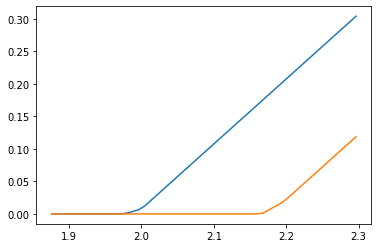

In [405]:
#F^{(2)} at first stage
import numpy as np
import matplotlib.pyplot as plt

prob_first_stage = [sum(scenario[0][s][t][2] for t in range(T)) for s in range(S)]

v_bm_p = [[v_bm[s], prob_first_stage[s]] for s in range(S)]
v_bm_p.sort()

v_ssd_p = [[v_ssd[s], prob_first_stage[s]] for s in range(S)]
v_ssd_p.sort()

x_min = min(min([v_bm,v_ssd])) - 0.1
x_max = max(max([v_bm,v_ssd])) + 0.1
x_axis = np.linspace(x_min,x_max,50)

y_axis_bm = [sum(v_bm_p[s][1]*max(0,(x-v_bm_p[s][0])) for s in range(S)) for x in x_axis]

y_axis_ssd = [sum(v_ssd_p[s][1]*max(0,(x-v_ssd_p[s][0])) for s in range(S)) for x in x_axis]

plt.figure()
plt.plot(x_axis, y_axis_bm, color='tab:blue') #benchmark
plt.plot(x_axis, y_axis_ssd, color='tab:orange')

In [30]:
v_bm,v_ssd, x_bm, x_ssd

([0.72, 0.72, 0.72],
 [0.7533917736278078, 0.7311509345550185, 0.72],
 [5.0, 0.0, 0.0],
 [4.099196689941724, 0.0, 0.9008033100582757])

In [43]:
#m = gp.Model("m")
#x = m.addVar(vtype=GRB.CONTINUOUS, name="x", lb=0)
#y = m.addVar(vtype=GRB.CONTINUOUS, name="y", lb=0)
#m.setObjective(x-y, GRB.MINIMIZE)
#m.addConstr((x==1)>>(y-2*x<=0), name = "quad")
#m.addConstr((x==0)>>(y+x==0), name = "constant")
#m.optimize()

In [648]:
a=[3+i for i in range(3)]
[a[i]*0.8 for i in range(len(a))]

[2.4000000000000004, 3.2, 4.0]

In [137]:
def func(x):
    return x, x**2

(a,_) = func(2)
a

2

In [113]:
ab = (np.ones(3)).tolist()
#ab = ab.tolist()
ab

[1.0, 1.0, 1.0]

In [191]:
for i in range(0,3):
    print(i)

0
1
2
